Predicting the cuisine type of an image of a dish using BoW reprsentation for the ingredients.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from utils.output_utils import get_ingrs
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '.../finalDemo'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [6]:
ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [7]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = True
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)

C:\Users\nikos\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 22.70090126991272


In [8]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [9]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

In [13]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

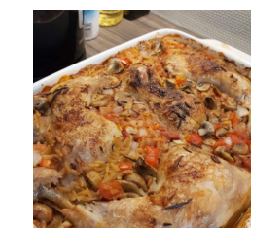

['pepper', 'chicken', 'carrot', 'onion', 'salt', 'butter', 'mushroom', 'thyme', 'oil']


In [14]:
ingredients = []
img_names = []
for img_file in demo_files:

    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()

    gen_ingrs = get_ingrs(ingr_ids[0], ingrs_vocab)
    ingredients.append(gen_ingrs)
    img_names.append(img_file)
    print(gen_ingrs)

In [22]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from ast import literal_eval
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import pickle

In [24]:
with open('BoWvectorizerv2.pk', 'rb') as pickle_file:
    cvector = pickle.load(pickle_file)
model = load_model('BoWmodelv2.h5')

In [41]:
cuisines = ['greek','american','indian','spanish','italian','mexican','chinese',
 'british','thai','french','japanese','korean']

st = ' '.join(gen_ingrs)

X_test = cvector.transform([st])
y_pred =model.predict(X_test)
print(cuisines[np.argmax(y_pred)])

american
